In [1]:
import bt as bt
import pandas as pd
import numpy as np
import datetime
from alphas import Alphas
from copy import deepcopy
from datas import *

In [2]:
# 获取股票数据
year = 2024
list_assets, df_assets = get_hs300_stocks(f'{year}-01-01')
df_org= get_all_date_data(f'{year}-01-01', f'{year+1}-01-01', list_assets)

df1 = df_org.rename(columns={
        "date": "datetime", 
        "asset": "sec_code"})
df1 = df1[['datetime', "sec_code", "close"]]
df1['datetime'] = pd.to_datetime(df1['datetime'])
df_price = df1.pivot(index='datetime', columns='sec_code')
df_price.loc[:,['close']] = df_price.loc[:,['close']].shift(-1) #对价格进行移位，即买卖时要用第二天的价格（更精确的用开盘价更好，这里先用收盘价）
df_price.loc[:,['close']] = df_price.loc[:,['close']].fillna(method='pad')#用前面日期的值填空nan值

login success!
login respond error_code:0
login respond  error_msg:success
query_hs300 error_code:0
query_hs300  error_msg:success
logout success!
300


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\444490695.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_price.loc[:,['close']] = df_price.loc[:,['close']].fillna(method='pad')#用前面日期的值填空nan值


In [3]:
# 获取基准数据
df_bench = Alphas.get_benchmark(2024, 'sh000300')
# 可以设置开始时间、结束时间
# df_bench = Alphas.get_benchmark2(2023, 'sh000300')
df2 = df_bench.rename(columns={'date':'datetime'})
df2["sec_code"] = 'sh000300'
df2 = df2[['datetime', "sec_code", "close"]]
df2['datetime'] = pd.to_datetime(df2['datetime'])
df_bench = df2.pivot(index='datetime', columns='sec_code')
df_bench.loc[:,['close']] = df_bench.loc[:,['close']].fillna(method='pad')#用前面日期的值填空nan值
display(df_bench)

C:\Users\华为\AppData\Local\Temp\ipykernel_15232\1399258553.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bench.loc[:,['close']] = df_bench.loc[:,['close']].fillna(method='pad')#用前面日期的值填空nan值


,close
sec_code,sh000300
datetime,
2023-01-03,3887.899
2023-01-04,3892.948
2023-01-05,3968.578
2023-01-06,3980.889
2023-01-09,4013.120
...,...
2024-07-01,3478.183
2024-07-02,3471.786


In [4]:
# 获取因子
df_2 = df_org[['date', 'asset', "close"]]
df_2['date'] = pd.to_datetime(df_2['date'])
# print(df_all)

close = df_2.pivot(index='date', columns='asset', values='close')

alpha_name = 'Alphas101'
alpha_num = 11

# 读取已经计算好的因子
alpha = pd.read_csv('alphas/{}/{}/alpha{:03d}.csv'.format(alpha_name, year, alpha_num))

# 筛选出今年的数据，需与股票收盘日期区间一致
alpha = alpha[(alpha['date'] >= f'{year}-01-01') & (alpha['date'] <= f'{year+1}-01-01')]

# 因子矩阵转换为一维数据(alphalens需要的格式)
alpha = alpha.melt(id_vars=['date'], var_name='asset', value_name='factor' )

# date列转为日期格式
alpha['date'] = pd.to_datetime(alpha['date'])
alpha = alpha[['date', 'asset', 'factor']]

# 设置二级索引
alpha = alpha.set_index(['date', 'asset'], drop=True)
alpha.sort_index(inplace=True)

C:\Users\华为\AppData\Local\Temp\ipykernel_15232\3741931441.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['date'] = pd.to_datetime(df_2['date'])


In [24]:
# 通过因子设计买入信号（批量模式）
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_full_tear_sheet
alpha_name = 'Alphas101'
alpha_all = 101
except_alpha = [48,56,58,59,63,67,69,70,76,79,80,82,87,89,90,91,93,97,100]

# 创建一个对象字典
obj_dict = {f"obj_{i+1}": pd.DataFrame() for i in range(alpha_all)}

for i in range(alpha_all):
    i = i + 1
    if i in except_alpha:
        continue

    # 读取已经计算好的因子
    alpha = pd.read_csv('alphas/{}/{}/alpha{:03d}.csv'.format(alpha_name, year, i))

    # 筛选出今年的数据，需与股票收盘日期区间一致
    alpha = alpha[(alpha['date'] >= f'{year}-01-01') & (alpha['date'] <= f'{year+1}-01-01')]

    # 因子矩阵转换为一维数据(alphalens需要的格式)
    alpha = alpha.melt(id_vars=['date'], var_name='asset', value_name='factor' )

    # date列转为日期格式
    alpha['date'] = pd.to_datetime(alpha['date'])
    alpha = alpha[['date', 'asset', 'factor']]

    # 设置二级索引
    alpha = alpha.set_index(['date', 'asset'], drop=True)
    alpha.sort_index(inplace=True)

    ret = get_clean_factor_and_forward_returns(alpha, close, quantiles=10, periods=[1], max_loss=1)
    ret = ret.reset_index()

    ret = ret[ret['factor_quantile'] == 10]
    ret = ret[['date','asset']]
    ret['close'] = True

    trade_info = ret.rename(columns={
            "date": "trade_date", 
            "asset": "sec_code"})

    trade_info = trade_info.pivot(index='trade_date', columns='sec_code')
    trade_info.loc[:,:] = trade_info.loc[:,:].fillna(value=False)#用前面日期的值填空nan值
    obj_dict[f'obj_{i}'].value = trade_info
    print(f'alpha_{i} ok.')

C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(peri

Dropped 100.0% entries from factor data: 0.9% in forward returns computation and 99.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_1 ok.
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


alpha_2 ok.
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_3 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(peri

Dropped 100.0% entries from factor data: 0.9% in forward returns computation and 99.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_4 ok.
Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_5 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_6 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 95.9% entries from factor data: 1.0% in forward returns computation and 95.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_7 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_8 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_9 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_10 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_11 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_12 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_13 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_14 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_15 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_16 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_17 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_18 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 8.3% entries from factor data: 8.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_19 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_20 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(peri

Dropped 100.0% entries from factor data: 0.8% in forward returns computation and 99.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_21 ok.
Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


alpha_22 ok.
Dropped 90.2% entries from factor data: 0.8% in forward returns computation and 89.3% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_23 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 11.5% entries from factor data: 0.8% in forward returns computation and 10.7% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_24 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 8.3% entries from factor data: 0.9% in forward returns computation and 7.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_25 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 2.5% entries from factor data: 0.8% in forward returns computation and 1.6% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_26 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 100.0% entries from factor data: 0.8% in forward returns computation and 99.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_27 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_28 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_29 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_30 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_31 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_32 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_33 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_34 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 69.7% entries from factor data: 0.9% in forward returns computation and 68.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_35 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 1.4% entries from factor data: 1.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_36 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_37 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_38 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 8.3% entries from factor data: 8.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_39 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_40 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_41 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_42 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 4.2% entries from factor data: 0.9% in forward returns computation and 3.3% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_43 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_44 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_45 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(peri

Dropped 100.0% entries from factor data: 0.8% in forward returns computation and 99.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_46 ok.
Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_47 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 72.1% entries from factor data: 0.8% in forward returns computation and 71.3% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_49 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_50 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 89.3% entries from factor data: 0.8% in forward returns computation and 88.5% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_51 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 1.7% entries from factor data: 1.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_52 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_53 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 10.7% entries from factor data: 0.8% in forward returns computation and 9.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_54 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_55 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_57 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_60 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 100.0% entries from factor data: 0.8% in forward returns computation and 99.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_61 ok.
Dropped 100.0% entries from factor data: 0.8% in forward returns computation and 99.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_62 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(peri

Dropped 100.0% entries from factor data: 0.8% in forward returns computation and 99.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_64 ok.
Dropped 100.0% entries from factor data: 0.8% in forward returns computation and 99.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_65 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarn

Dropped 19.8% entries from factor data: 19.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_66 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(peri

Dropped 100.0% entries from factor data: 0.8% in forward returns computation and 99.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_68 ok.
Dropped 100.0% entries from factor data: 0.9% in forward returns computation and 99.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_71 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_72 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 66.4% entries from factor data: 0.9% in forward returns computation and 65.5% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_73 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 100.0% entries from factor data: 0.8% in forward returns computation and 99.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_74 ok.
Dropped 100.0% entries from factor data: 0.8% in forward returns computation and 99.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_75 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarn

Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_77 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_78 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(peri

Dropped 100.0% entries from factor data: 0.8% in forward returns computation and 99.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_81 ok.
Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_83 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 41.0% entries from factor data: 0.9% in forward returns computation and 40.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_84 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_85 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 100.0% entries from factor data: 0.8% in forward returns computation and 99.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_86 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 0.9% entries from factor data: 0.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_88 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 100.0% entries from factor data: 0.8% in forward returns computation and 99.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_92 ok.
Dropped 45.1% entries from factor data: 0.9% in forward returns computation and 44.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_94 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(peri

Dropped 100.0% entries from factor data: 0.8% in forward returns computation and 99.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_95 ok.
Dropped 100.0% entries from factor data: 0.8% in forward returns computation and 99.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_96 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_98 ok.


C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info
C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


Dropped 100.0% entries from factor data: 0.8% in forward returns computation and 99.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_99 ok.
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
alpha_101 ok.


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
C:\Users\华为\AppData\Local\Temp\ipykernel_15232\2946020920.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obj_dict[f'obj_{i}'].value = trade_info


In [6]:
# 根据因子设计买入信号
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_full_tear_sheet

ret = get_clean_factor_and_forward_returns(alpha, close, quantiles=10, periods=[1], max_loss=1)
ret = ret.reset_index()

ret = ret[ret['factor_quantile'] == 10]
ret = ret[['date','asset']]

ret['close'] = True

trade_info = ret.rename(columns={
        "date": "trade_date", 
        "asset": "sec_code"})

trade_info = trade_info.pivot(index='trade_date', columns='sec_code')
trade_info.loc[:,:] = trade_info.loc[:,:].fillna(value=False)#用前面日期的值填空nan值

Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!


C:\Users\华为\AppData\Roaming\Python\Python311\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


In [25]:
class SelectTrade(bt.Algo):

    def __init__(self, signal, alpha:str):
        self.signal = signal
        self.alpha = alpha

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            print(f'{self.alpha} set selected {target.now}')
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])
            # display(selected)
            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected
        else:
            target.temp['selected'] = []
        # return True because we want to keep on moving down the stack
        return True

  0%|          | 0/2 [00:00<?, ?it/s]

alpha_1 set selected 2024-01-02 00:00:00
alpha_1 set selected 2024-01-03 00:00:00
alpha_1 set selected 2024-01-04 00:00:00
alpha_1 set selected 2024-01-05 00:00:00
alpha_1 set selected 2024-01-08 00:00:00
alpha_1 set selected 2024-01-09 00:00:00
alpha_1 set selected 2024-01-10 00:00:00
alpha_1 set selected 2024-01-11 00:00:00
alpha_1 set selected 2024-01-12 00:00:00
alpha_1 set selected 2024-01-15 00:00:00
alpha_1 set selected 2024-01-16 00:00:00
alpha_1 set selected 2024-01-17 00:00:00
alpha_1 set selected 2024-01-18 00:00:00
alpha_1 set selected 2024-01-19 00:00:00
alpha_1 set selected 2024-01-22 00:00:00
alpha_1 set selected 2024-01-23 00:00:00
alpha_1 set selected 2024-01-24 00:00:00
alpha_1 set selected 2024-01-25 00:00:00
alpha_1 set selected 2024-01-26 00:00:00
alpha_1 set selected 2024-01-29 00:00:00
alpha_1 set selected 2024-01-30 00:00:00
alpha_1 set selected 2024-01-31 00:00:00
alpha_1 set selected 2024-02-01 00:00:00
alpha_1 set selected 2024-02-02 00:00:00
alpha_1 set sele

100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


Stat                 alpha_1     sh000300
-------------------  ----------  ----------
Start                2024-01-02  2024-01-02
End                  2024-07-05  2024-07-05
Risk-free rate       0.00%       0.00%

Total Return         6.79%       1.32%
Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
CAGR                 13.85%      2.62%
Max Drawdown         -6.22%      -7.04%
Calmar Ratio         2.23        0.37

MTD                  -0.35%      -0.88%
3m                   -2.30%      -3.83%
6m                   6.71%       3.06%
YTD                  6.79%       1.32%
1Y                   -           -
3Y (ann.)            -           -
5Y (ann.)            -           -
10Y (ann.)           -           -
Since Incep. (ann.)  13.85%      2.62%

Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
Daily Mean (ann.)    15.00%      3.71%
Daily Vol (ann.)     16.31%      14.07%
Daily Skew           0.52        0.68
Daily Kurt           2

  0%|          | 0/2 [00:00<?, ?it/s]

alpha_2 set selected 2024-01-02 00:00:00
alpha_2 set selected 2024-01-03 00:00:00
alpha_2 set selected 2024-01-04 00:00:00
alpha_2 set selected 2024-01-05 00:00:00
alpha_2 set selected 2024-01-08 00:00:00
alpha_2 set selected 2024-01-09 00:00:00
alpha_2 set selected 2024-01-10 00:00:00
alpha_2 set selected 2024-01-11 00:00:00
alpha_2 set selected 2024-01-12 00:00:00
alpha_2 set selected 2024-01-15 00:00:00
alpha_2 set selected 2024-01-16 00:00:00
alpha_2 set selected 2024-01-17 00:00:00
alpha_2 set selected 2024-01-18 00:00:00
alpha_2 set selected 2024-01-19 00:00:00
alpha_2 set selected 2024-01-22 00:00:00
alpha_2 set selected 2024-01-23 00:00:00
alpha_2 set selected 2024-01-24 00:00:00
alpha_2 set selected 2024-01-25 00:00:00
alpha_2 set selected 2024-01-26 00:00:00
alpha_2 set selected 2024-01-29 00:00:00
alpha_2 set selected 2024-01-30 00:00:00
alpha_2 set selected 2024-01-31 00:00:00
alpha_2 set selected 2024-02-01 00:00:00
alpha_2 set selected 2024-02-02 00:00:00
alpha_2 set sele

100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Stat                 alpha_2     sh000300
-------------------  ----------  ----------
Start                2024-01-02  2024-01-02
End                  2024-07-05  2024-07-05
Risk-free rate       0.00%       0.00%

Total Return         6.79%       1.32%
Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
CAGR                 13.85%      2.62%
Max Drawdown         -6.22%      -7.04%
Calmar Ratio         2.23        0.37

MTD                  -0.35%      -0.88%
3m                   -2.30%      -3.83%
6m                   6.71%       3.06%
YTD                  6.79%       1.32%
1Y                   -           -
3Y (ann.)            -           -
5Y (ann.)            -           -
10Y (ann.)           -           -
Since Incep. (ann.)  13.85%      2.62%

Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
Daily Mean (ann.)    15.00%      3.71%
Daily Vol (ann.)     16.31%      14.07%
Daily Skew           0.52        0.68
Daily Kurt           2

  0%|          | 0/2 [00:00<?, ?it/s]

alpha_3 set selected 2024-01-02 00:00:00
alpha_3 set selected 2024-01-03 00:00:00
alpha_3 set selected 2024-01-04 00:00:00
alpha_3 set selected 2024-01-05 00:00:00
alpha_3 set selected 2024-01-08 00:00:00
alpha_3 set selected 2024-01-09 00:00:00
alpha_3 set selected 2024-01-10 00:00:00
alpha_3 set selected 2024-01-11 00:00:00
alpha_3 set selected 2024-01-12 00:00:00
alpha_3 set selected 2024-01-15 00:00:00
alpha_3 set selected 2024-01-16 00:00:00
alpha_3 set selected 2024-01-17 00:00:00
alpha_3 set selected 2024-01-18 00:00:00
alpha_3 set selected 2024-01-19 00:00:00
alpha_3 set selected 2024-01-22 00:00:00
alpha_3 set selected 2024-01-23 00:00:00
alpha_3 set selected 2024-01-24 00:00:00
alpha_3 set selected 2024-01-25 00:00:00
alpha_3 set selected 2024-01-26 00:00:00
alpha_3 set selected 2024-01-29 00:00:00
alpha_3 set selected 2024-01-30 00:00:00
alpha_3 set selected 2024-01-31 00:00:00
alpha_3 set selected 2024-02-01 00:00:00
alpha_3 set selected 2024-02-02 00:00:00
alpha_3 set sele

100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


Stat                 alpha_3     sh000300
-------------------  ----------  ----------
Start                2024-01-02  2024-01-02
End                  2024-07-05  2024-07-05
Risk-free rate       0.00%       0.00%

Total Return         6.79%       1.32%
Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
CAGR                 13.85%      2.62%
Max Drawdown         -6.22%      -7.04%
Calmar Ratio         2.23        0.37

MTD                  -0.35%      -0.88%
3m                   -2.30%      -3.83%
6m                   6.71%       3.06%
YTD                  6.79%       1.32%
1Y                   -           -
3Y (ann.)            -           -
5Y (ann.)            -           -
10Y (ann.)           -           -
Since Incep. (ann.)  13.85%      2.62%

Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
Daily Mean (ann.)    15.00%      3.71%
Daily Vol (ann.)     16.31%      14.07%
Daily Skew           0.52        0.68
Daily Kurt           2

  0%|          | 0/2 [00:00<?, ?it/s]

alpha_4 set selected 2024-01-02 00:00:00
alpha_4 set selected 2024-01-03 00:00:00
alpha_4 set selected 2024-01-04 00:00:00
alpha_4 set selected 2024-01-05 00:00:00
alpha_4 set selected 2024-01-08 00:00:00
alpha_4 set selected 2024-01-09 00:00:00
alpha_4 set selected 2024-01-10 00:00:00
alpha_4 set selected 2024-01-11 00:00:00
alpha_4 set selected 2024-01-12 00:00:00
alpha_4 set selected 2024-01-15 00:00:00
alpha_4 set selected 2024-01-16 00:00:00
alpha_4 set selected 2024-01-17 00:00:00
alpha_4 set selected 2024-01-18 00:00:00
alpha_4 set selected 2024-01-19 00:00:00
alpha_4 set selected 2024-01-22 00:00:00
alpha_4 set selected 2024-01-23 00:00:00
alpha_4 set selected 2024-01-24 00:00:00
alpha_4 set selected 2024-01-25 00:00:00
alpha_4 set selected 2024-01-26 00:00:00
alpha_4 set selected 2024-01-29 00:00:00
alpha_4 set selected 2024-01-30 00:00:00
alpha_4 set selected 2024-01-31 00:00:00
alpha_4 set selected 2024-02-01 00:00:00
alpha_4 set selected 2024-02-02 00:00:00
alpha_4 set sele

100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Stat                 alpha_4     sh000300
-------------------  ----------  ----------
Start                2024-01-02  2024-01-02
End                  2024-07-05  2024-07-05
Risk-free rate       0.00%       0.00%

Total Return         6.79%       1.32%
Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
CAGR                 13.85%      2.62%
Max Drawdown         -6.22%      -7.04%
Calmar Ratio         2.23        0.37

MTD                  -0.35%      -0.88%
3m                   -2.30%      -3.83%
6m                   6.71%       3.06%
YTD                  6.79%       1.32%
1Y                   -           -
3Y (ann.)            -           -
5Y (ann.)            -           -
10Y (ann.)           -           -
Since Incep. (ann.)  13.85%      2.62%

Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
Daily Mean (ann.)    15.00%      3.71%
Daily Vol (ann.)     16.31%      14.07%
Daily Skew           0.52        0.68
Daily Kurt           2

  0%|          | 0/2 [00:00<?, ?it/s]

alpha_5 set selected 2024-01-02 00:00:00
alpha_5 set selected 2024-01-03 00:00:00
alpha_5 set selected 2024-01-04 00:00:00
alpha_5 set selected 2024-01-05 00:00:00
alpha_5 set selected 2024-01-08 00:00:00
alpha_5 set selected 2024-01-09 00:00:00
alpha_5 set selected 2024-01-10 00:00:00
alpha_5 set selected 2024-01-11 00:00:00
alpha_5 set selected 2024-01-12 00:00:00
alpha_5 set selected 2024-01-15 00:00:00
alpha_5 set selected 2024-01-16 00:00:00
alpha_5 set selected 2024-01-17 00:00:00
alpha_5 set selected 2024-01-18 00:00:00
alpha_5 set selected 2024-01-19 00:00:00
alpha_5 set selected 2024-01-22 00:00:00
alpha_5 set selected 2024-01-23 00:00:00
alpha_5 set selected 2024-01-24 00:00:00
alpha_5 set selected 2024-01-25 00:00:00
alpha_5 set selected 2024-01-26 00:00:00
alpha_5 set selected 2024-01-29 00:00:00
alpha_5 set selected 2024-01-30 00:00:00
alpha_5 set selected 2024-01-31 00:00:00
alpha_5 set selected 2024-02-01 00:00:00
alpha_5 set selected 2024-02-02 00:00:00
alpha_5 set sele

100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Stat                 alpha_5     sh000300
-------------------  ----------  ----------
Start                2024-01-02  2024-01-02
End                  2024-07-05  2024-07-05
Risk-free rate       0.00%       0.00%

Total Return         6.79%       1.32%
Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
CAGR                 13.85%      2.62%
Max Drawdown         -6.22%      -7.04%
Calmar Ratio         2.23        0.37

MTD                  -0.35%      -0.88%
3m                   -2.30%      -3.83%
6m                   6.71%       3.06%
YTD                  6.79%       1.32%
1Y                   -           -
3Y (ann.)            -           -
5Y (ann.)            -           -
10Y (ann.)           -           -
Since Incep. (ann.)  13.85%      2.62%

Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
Daily Mean (ann.)    15.00%      3.71%
Daily Vol (ann.)     16.31%      14.07%
Daily Skew           0.52        0.68
Daily Kurt           2

  0%|          | 0/2 [00:00<?, ?it/s]

alpha_6 set selected 2024-01-02 00:00:00
alpha_6 set selected 2024-01-03 00:00:00
alpha_6 set selected 2024-01-04 00:00:00
alpha_6 set selected 2024-01-05 00:00:00
alpha_6 set selected 2024-01-08 00:00:00
alpha_6 set selected 2024-01-09 00:00:00
alpha_6 set selected 2024-01-10 00:00:00
alpha_6 set selected 2024-01-11 00:00:00
alpha_6 set selected 2024-01-12 00:00:00
alpha_6 set selected 2024-01-15 00:00:00
alpha_6 set selected 2024-01-16 00:00:00
alpha_6 set selected 2024-01-17 00:00:00
alpha_6 set selected 2024-01-18 00:00:00
alpha_6 set selected 2024-01-19 00:00:00
alpha_6 set selected 2024-01-22 00:00:00
alpha_6 set selected 2024-01-23 00:00:00
alpha_6 set selected 2024-01-24 00:00:00
alpha_6 set selected 2024-01-25 00:00:00
alpha_6 set selected 2024-01-26 00:00:00
alpha_6 set selected 2024-01-29 00:00:00
alpha_6 set selected 2024-01-30 00:00:00
alpha_6 set selected 2024-01-31 00:00:00
alpha_6 set selected 2024-02-01 00:00:00
alpha_6 set selected 2024-02-02 00:00:00
alpha_6 set sele

100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


Stat                 alpha_6     sh000300
-------------------  ----------  ----------
Start                2024-01-02  2024-01-02
End                  2024-07-05  2024-07-05
Risk-free rate       0.00%       0.00%

Total Return         6.79%       1.32%
Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
CAGR                 13.85%      2.62%
Max Drawdown         -6.22%      -7.04%
Calmar Ratio         2.23        0.37

MTD                  -0.35%      -0.88%
3m                   -2.30%      -3.83%
6m                   6.71%       3.06%
YTD                  6.79%       1.32%
1Y                   -           -
3Y (ann.)            -           -
5Y (ann.)            -           -
10Y (ann.)           -           -
Since Incep. (ann.)  13.85%      2.62%

Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
Daily Mean (ann.)    15.00%      3.71%
Daily Vol (ann.)     16.31%      14.07%
Daily Skew           0.52        0.68
Daily Kurt           2

  0%|          | 0/2 [00:00<?, ?it/s]

alpha_7 set selected 2024-01-02 00:00:00
alpha_7 set selected 2024-01-03 00:00:00
alpha_7 set selected 2024-01-04 00:00:00
alpha_7 set selected 2024-01-05 00:00:00
alpha_7 set selected 2024-01-08 00:00:00
alpha_7 set selected 2024-01-09 00:00:00
alpha_7 set selected 2024-01-10 00:00:00
alpha_7 set selected 2024-01-11 00:00:00
alpha_7 set selected 2024-01-12 00:00:00
alpha_7 set selected 2024-01-15 00:00:00
alpha_7 set selected 2024-01-16 00:00:00
alpha_7 set selected 2024-01-17 00:00:00
alpha_7 set selected 2024-01-18 00:00:00
alpha_7 set selected 2024-01-19 00:00:00
alpha_7 set selected 2024-01-22 00:00:00
alpha_7 set selected 2024-01-23 00:00:00
alpha_7 set selected 2024-01-24 00:00:00
alpha_7 set selected 2024-01-25 00:00:00
alpha_7 set selected 2024-01-26 00:00:00
alpha_7 set selected 2024-01-29 00:00:00
alpha_7 set selected 2024-01-30 00:00:00
alpha_7 set selected 2024-01-31 00:00:00
alpha_7 set selected 2024-02-01 00:00:00
alpha_7 set selected 2024-02-02 00:00:00
alpha_7 set sele

100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Stat                 alpha_7     sh000300
-------------------  ----------  ----------
Start                2024-01-02  2024-01-02
End                  2024-07-05  2024-07-05
Risk-free rate       0.00%       0.00%

Total Return         6.79%       1.32%
Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
CAGR                 13.85%      2.62%
Max Drawdown         -6.22%      -7.04%
Calmar Ratio         2.23        0.37

MTD                  -0.35%      -0.88%
3m                   -2.30%      -3.83%
6m                   6.71%       3.06%
YTD                  6.79%       1.32%
1Y                   -           -
3Y (ann.)            -           -
5Y (ann.)            -           -
10Y (ann.)           -           -
Since Incep. (ann.)  13.85%      2.62%

Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
Daily Mean (ann.)    15.00%      3.71%
Daily Vol (ann.)     16.31%      14.07%
Daily Skew           0.52        0.68
Daily Kurt           2

 50%|█████     | 1/2 [00:00<00:00,  1.49it/s]

alpha_8 set selected 2024-01-02 00:00:00
alpha_8 set selected 2024-01-03 00:00:00
alpha_8 set selected 2024-01-04 00:00:00
alpha_8 set selected 2024-01-05 00:00:00
alpha_8 set selected 2024-01-08 00:00:00
alpha_8 set selected 2024-01-09 00:00:00
alpha_8 set selected 2024-01-10 00:00:00
alpha_8 set selected 2024-01-11 00:00:00
alpha_8 set selected 2024-01-12 00:00:00
alpha_8 set selected 2024-01-15 00:00:00
alpha_8 set selected 2024-01-16 00:00:00
alpha_8 set selected 2024-01-17 00:00:00
alpha_8 set selected 2024-01-18 00:00:00
alpha_8 set selected 2024-01-19 00:00:00
alpha_8 set selected 2024-01-22 00:00:00
alpha_8 set selected 2024-01-23 00:00:00
alpha_8 set selected 2024-01-24 00:00:00
alpha_8 set selected 2024-01-25 00:00:00
alpha_8 set selected 2024-01-26 00:00:00
alpha_8 set selected 2024-01-29 00:00:00
alpha_8 set selected 2024-01-30 00:00:00
alpha_8 set selected 2024-01-31 00:00:00
alpha_8 set selected 2024-02-01 00:00:00
alpha_8 set selected 2024-02-02 00:00:00
alpha_8 set sele

100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Stat                 alpha_8     sh000300
-------------------  ----------  ----------
Start                2024-01-02  2024-01-02
End                  2024-07-05  2024-07-05
Risk-free rate       0.00%       0.00%

Total Return         6.79%       1.32%
Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
CAGR                 13.85%      2.62%
Max Drawdown         -6.22%      -7.04%
Calmar Ratio         2.23        0.37

MTD                  -0.35%      -0.88%
3m                   -2.30%      -3.83%
6m                   6.71%       3.06%
YTD                  6.79%       1.32%
1Y                   -           -
3Y (ann.)            -           -
5Y (ann.)            -           -
10Y (ann.)           -           -
Since Incep. (ann.)  13.85%      2.62%

Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
Daily Mean (ann.)    15.00%      3.71%
Daily Vol (ann.)     16.31%      14.07%
Daily Skew           0.52        0.68
Daily Kurt           2

  0%|          | 0/2 [00:00<?, ?it/s]

alpha_9 set selected 2024-01-02 00:00:00
alpha_9 set selected 2024-01-03 00:00:00
alpha_9 set selected 2024-01-04 00:00:00
alpha_9 set selected 2024-01-05 00:00:00
alpha_9 set selected 2024-01-08 00:00:00
alpha_9 set selected 2024-01-09 00:00:00
alpha_9 set selected 2024-01-10 00:00:00
alpha_9 set selected 2024-01-11 00:00:00
alpha_9 set selected 2024-01-12 00:00:00
alpha_9 set selected 2024-01-15 00:00:00
alpha_9 set selected 2024-01-16 00:00:00
alpha_9 set selected 2024-01-17 00:00:00
alpha_9 set selected 2024-01-18 00:00:00
alpha_9 set selected 2024-01-19 00:00:00
alpha_9 set selected 2024-01-22 00:00:00
alpha_9 set selected 2024-01-23 00:00:00
alpha_9 set selected 2024-01-24 00:00:00
alpha_9 set selected 2024-01-25 00:00:00
alpha_9 set selected 2024-01-26 00:00:00
alpha_9 set selected 2024-01-29 00:00:00
alpha_9 set selected 2024-01-30 00:00:00
alpha_9 set selected 2024-01-31 00:00:00
alpha_9 set selected 2024-02-01 00:00:00
alpha_9 set selected 2024-02-02 00:00:00
alpha_9 set sele

100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Stat                 alpha_9     sh000300
-------------------  ----------  ----------
Start                2024-01-02  2024-01-02
End                  2024-07-05  2024-07-05
Risk-free rate       0.00%       0.00%

Total Return         6.79%       1.32%
Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
CAGR                 13.85%      2.62%
Max Drawdown         -6.22%      -7.04%
Calmar Ratio         2.23        0.37

MTD                  -0.35%      -0.88%
3m                   -2.30%      -3.83%
6m                   6.71%       3.06%
YTD                  6.79%       1.32%
1Y                   -           -
3Y (ann.)            -           -
5Y (ann.)            -           -
10Y (ann.)           -           -
Since Incep. (ann.)  13.85%      2.62%

Daily Sharpe         0.92        0.26
Daily Sortino        1.73        0.52
Daily Mean (ann.)    15.00%      3.71%
Daily Vol (ann.)     16.31%      14.07%
Daily Skew           0.52        0.68
Daily Kurt           2

  0%|          | 0/2 [00:00<?, ?it/s]

alpha_10 set selected 2024-01-02 00:00:00
alpha_10 set selected 2024-01-03 00:00:00
alpha_10 set selected 2024-01-04 00:00:00
alpha_10 set selected 2024-01-05 00:00:00
alpha_10 set selected 2024-01-08 00:00:00
alpha_10 set selected 2024-01-09 00:00:00
alpha_10 set selected 2024-01-10 00:00:00
alpha_10 set selected 2024-01-11 00:00:00
alpha_10 set selected 2024-01-12 00:00:00
alpha_10 set selected 2024-01-15 00:00:00
alpha_10 set selected 2024-01-16 00:00:00
alpha_10 set selected 2024-01-17 00:00:00
alpha_10 set selected 2024-01-18 00:00:00
alpha_10 set selected 2024-01-19 00:00:00
alpha_10 set selected 2024-01-22 00:00:00
alpha_10 set selected 2024-01-23 00:00:00
alpha_10 set selected 2024-01-24 00:00:00
alpha_10 set selected 2024-01-25 00:00:00
alpha_10 set selected 2024-01-26 00:00:00
alpha_10 set selected 2024-01-29 00:00:00
alpha_10 set selected 2024-01-30 00:00:00
alpha_10 set selected 2024-01-31 00:00:00
alpha_10 set selected 2024-02-01 00:00:00
alpha_10 set selected 2024-02-02 0

100%|██████████| 2/2 [00:00<00:00,  2.57it/s]


alpha_10 set selected 2024-04-01 00:00:00
alpha_10 set selected 2024-04-02 00:00:00
alpha_10 set selected 2024-04-03 00:00:00
alpha_10 set selected 2024-04-08 00:00:00
alpha_10 set selected 2024-04-09 00:00:00
alpha_10 set selected 2024-04-10 00:00:00
alpha_10 set selected 2024-04-11 00:00:00
alpha_10 set selected 2024-04-12 00:00:00
alpha_10 set selected 2024-04-15 00:00:00
alpha_10 set selected 2024-04-16 00:00:00
alpha_10 set selected 2024-04-17 00:00:00
alpha_10 set selected 2024-04-18 00:00:00
alpha_10 set selected 2024-04-19 00:00:00
alpha_10 set selected 2024-04-22 00:00:00
alpha_10 set selected 2024-04-23 00:00:00
alpha_10 set selected 2024-04-24 00:00:00
alpha_10 set selected 2024-04-25 00:00:00
alpha_10 set selected 2024-04-26 00:00:00
alpha_10 set selected 2024-04-29 00:00:00
alpha_10 set selected 2024-04-30 00:00:00
alpha_10 set selected 2024-05-06 00:00:00
alpha_10 set selected 2024-05-07 00:00:00
alpha_10 set selected 2024-05-08 00:00:00
alpha_10 set selected 2024-05-09 

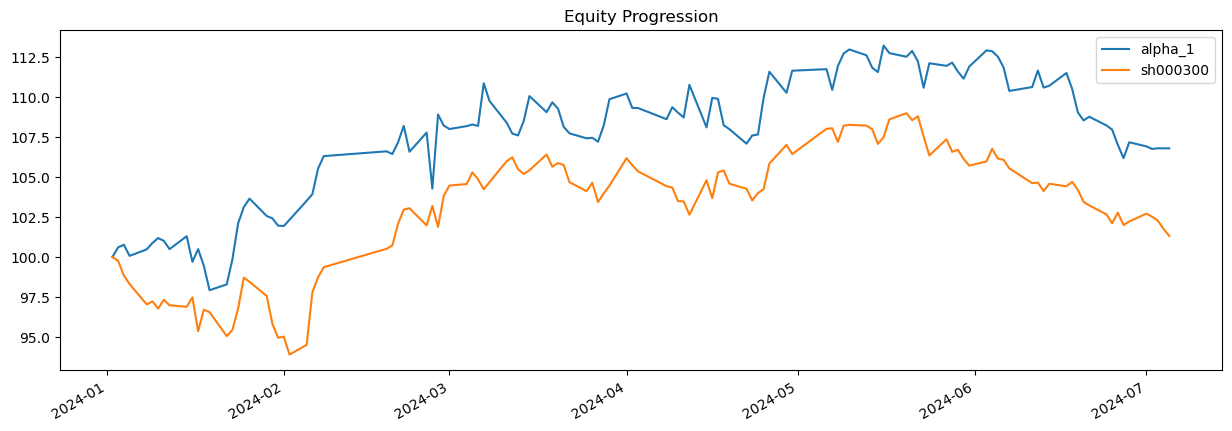

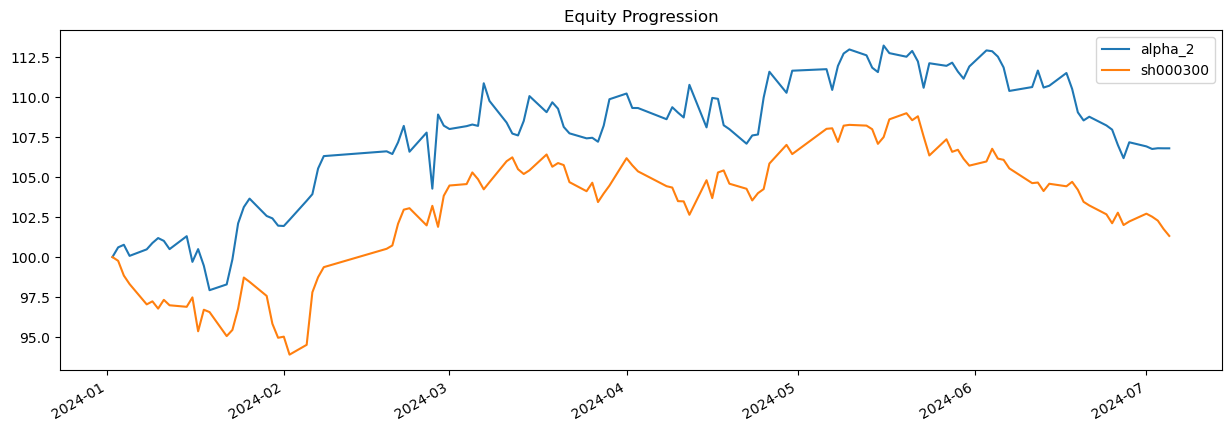

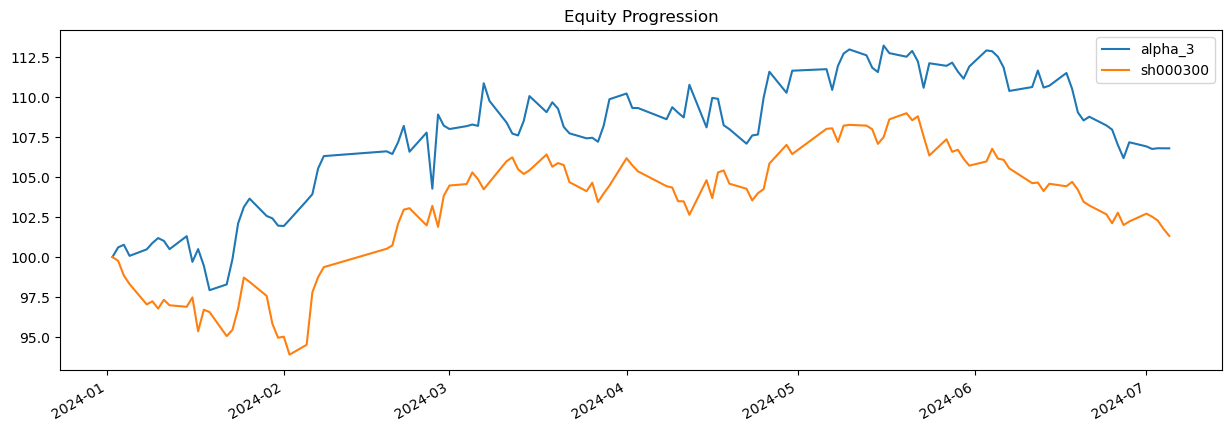

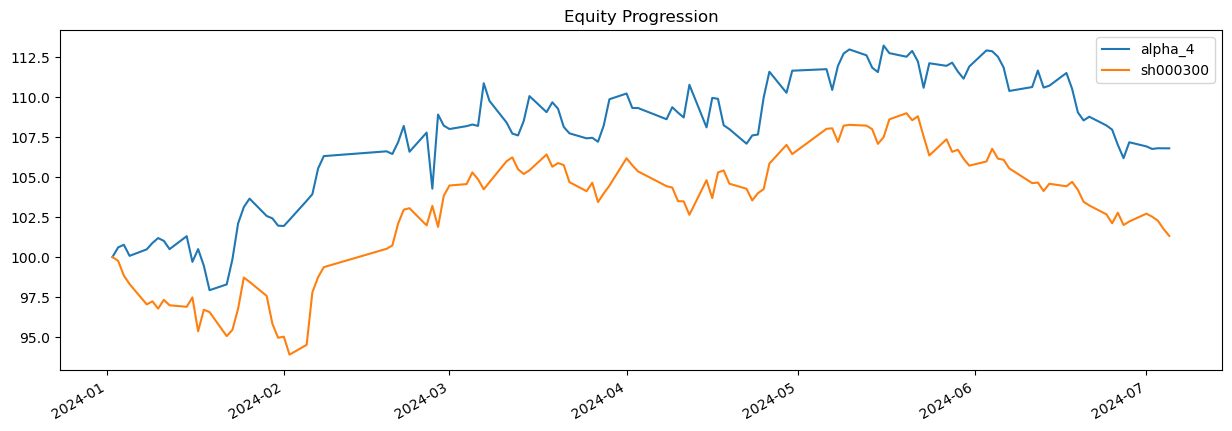

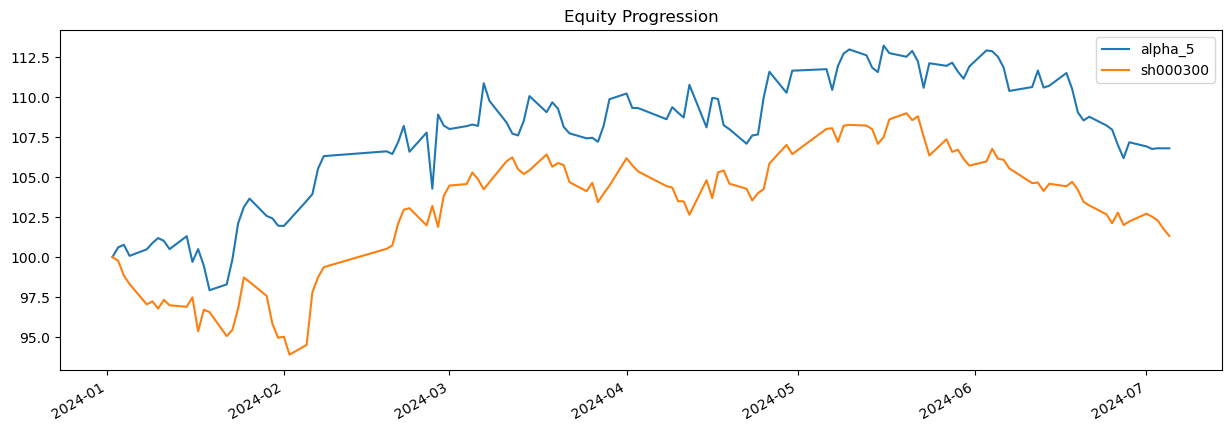

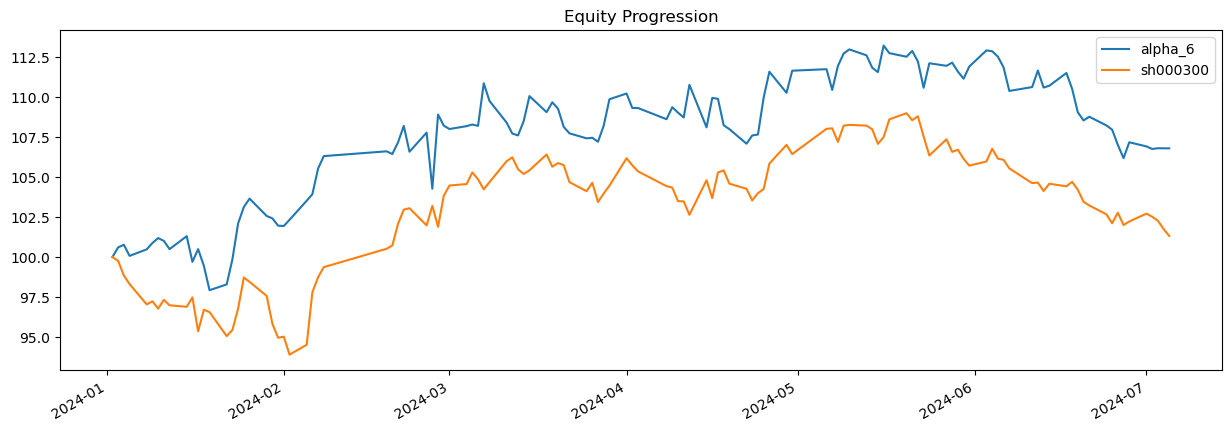

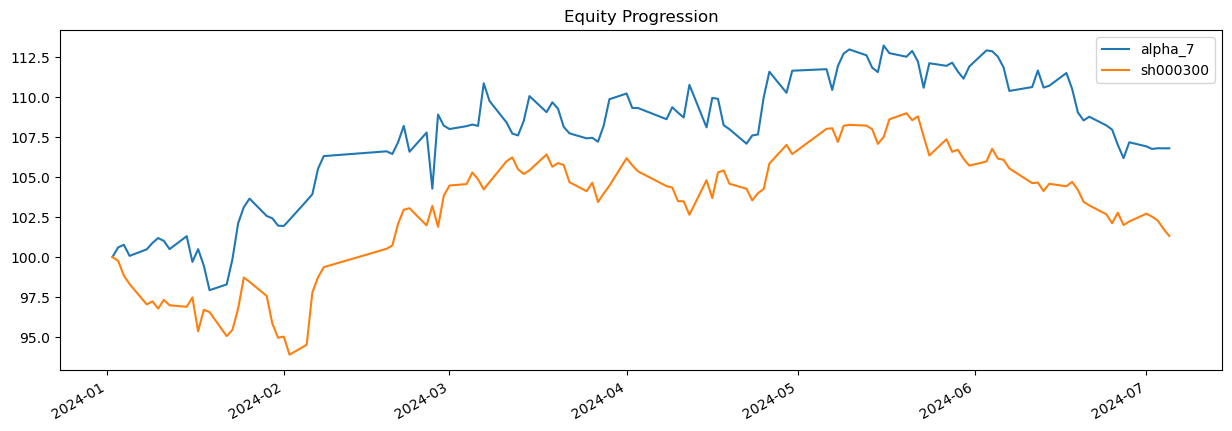

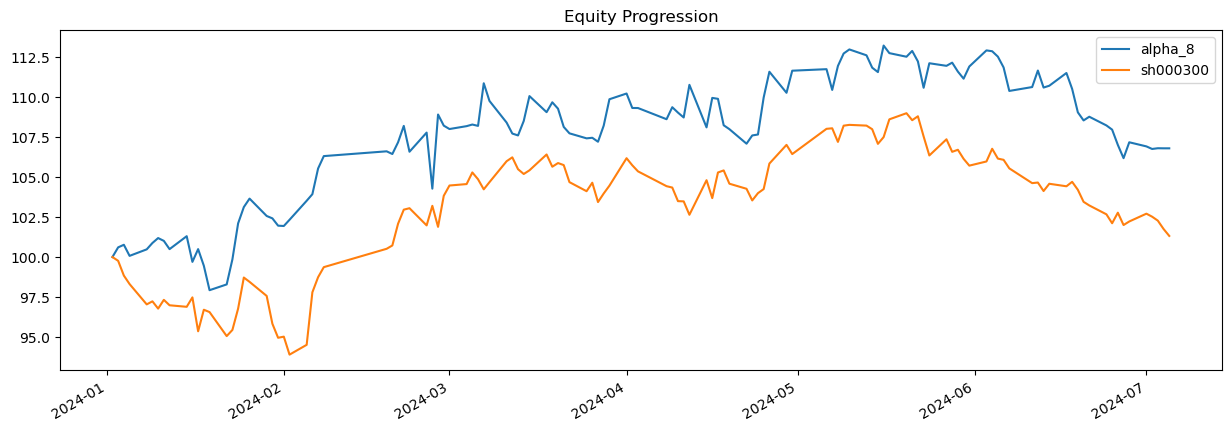

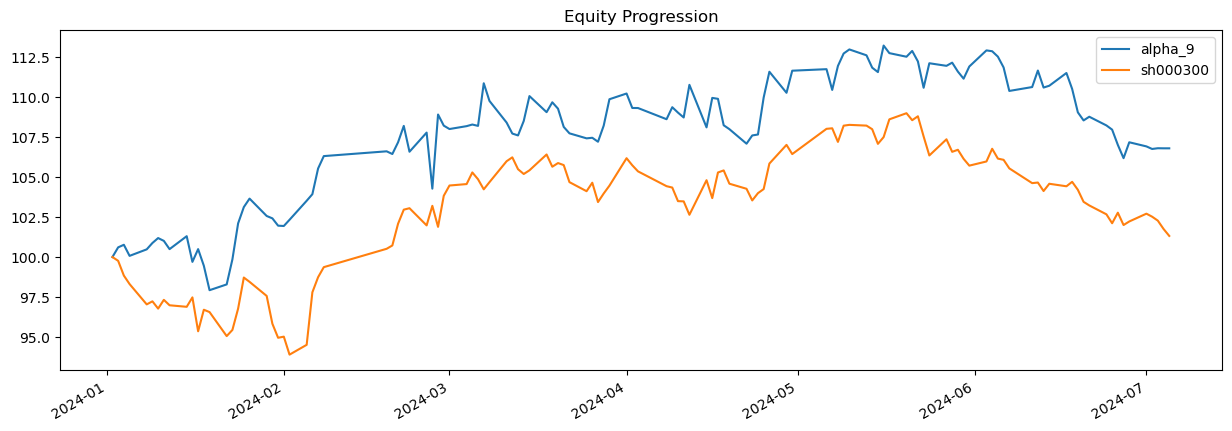

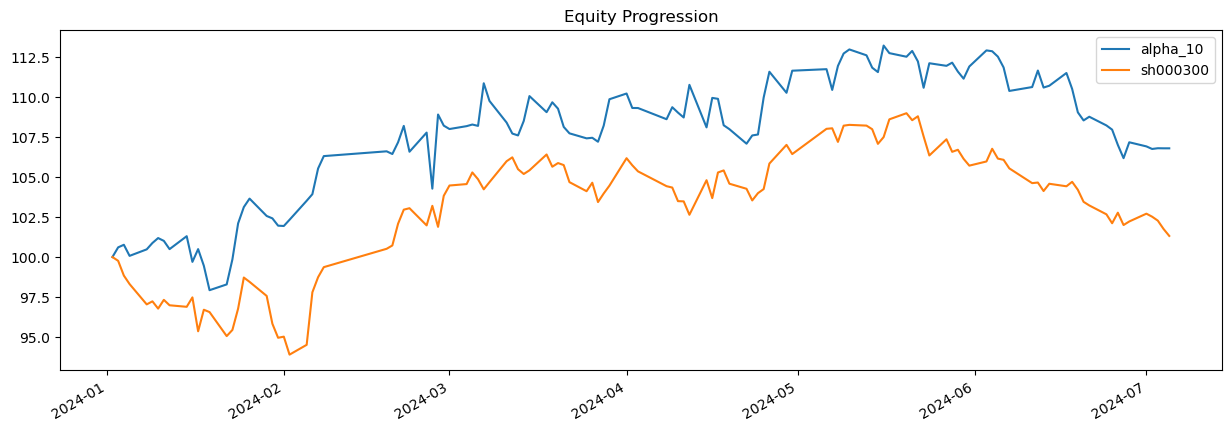

In [26]:
# alpha_all = 101
for i in range(10):
    i = i+1
    s = bt.Strategy(f'alpha_{i}', [SelectTrade(trade_info, f'alpha_{i}'),
                        bt.algos.WeighEqually(),
                        bt.algos.Rebalance()])
    s2 = bt.Strategy('sh000300', [bt.algos.RunOnce(),
                            bt.algos.SelectAll(),
                            bt.algos.WeighEqually(),
                            bt.algos.Rebalance()])
    # now we create the Backtest
    t = bt.Backtest(s, df_price)
    t2 = bt.Backtest(s2, df_bench)
    # and let's run it!
    res = bt.run(t, t2)
    res.plot()
    res.display() 

# # create strategy
# s = bt.Strategy(f'alpha_{alpha_num}', [SelectTrade(trade_info, f'alpha_{alpha_num}'),
#                         bt.algos.WeighEqually(),
#                         bt.algos.Rebalance()])
# s2 = bt.Strategy('sh000300', [bt.algos.RunOnce(),
#                         bt.algos.SelectAll(),
#                         bt.algos.WeighEqually(),
#                         bt.algos.Rebalance()])
# # now we create the Backtest
# t = bt.Backtest(s, df_price)
# t2 = bt.Backtest(s2, df_bench)
# # and let's run it!
# res = bt.run(t, t2)
# res.plot()
# res.display()